Team Krøllebølle

Jakob Cetti Hansen (103353), Clara Hollenbeck (103326), Niklas Falke (105243)

# CatBoost model

## Setup

Requires Python 3.11 and Poetry 1.6. Run setup commands to begin:
```
!poetry install
!poetry run jupyter lab
```

Dependencies from pyproject.toml
```
python = "^3.11"
jupyter = "^1.0.0"
darts = "^0.26.0"
catboost = "^1.2.2"
```

In [1]:
import os
import numpy as np
import pandas as pd

pd.options.display.max_columns = None

Load data

In [2]:
def get_raw_data():
    return {
        "A": {
            "test_est": pd.read_parquet(os.path.join("data", "A", "X_test_estimated.parquet")),
            "train_est": pd.read_parquet(os.path.join("data", "A", "X_train_estimated.parquet")),
            "train_obs": pd.read_parquet(os.path.join("data", "A", "X_train_observed.parquet")),
            "train_tar": pd.read_parquet(os.path.join("data", "A", "train_targets.parquet")),
        },
        "B": {
            "test_est": pd.read_parquet(os.path.join("data", "B", "X_test_estimated.parquet")),
            "train_est": pd.read_parquet(os.path.join("data", "B", "X_train_estimated.parquet")),
            "train_obs": pd.read_parquet(os.path.join("data", "B", "X_train_observed.parquet")),
            "train_tar": pd.read_parquet(os.path.join("data", "B", "train_targets.parquet")),
        },
        "C": {
            "test_est": pd.read_parquet(os.path.join("data", "C", "X_test_estimated.parquet")),
            "train_est": pd.read_parquet(os.path.join("data", "C", "X_train_estimated.parquet")),
            "train_obs": pd.read_parquet(os.path.join("data", "C", "X_train_observed.parquet")),
            "train_tar": pd.read_parquet(os.path.join("data", "C", "train_targets.parquet")),
        },
    }
data = get_raw_data()

## Transform data

Transform the raw data to be on the X y form

In [3]:
def transform_data(data):
    # Create empty list of location train data and location test data
    Xs = {"og" : {loc : {} for loc in data}}
    ys = {"og" : {loc : {} for loc in data}}
    
    for loc in data:
        # Copy data
        data_obs = data[loc]["train_obs"].copy()
        data_est = data[loc]["train_est"].copy()
        data_test = data[loc]["test_est"].copy()
        data_tar = data[loc]["train_tar"].copy()
        
        # Add a column with the difference between date_forecast and date_calc in seconds and 
        data_obs["forecast_seconds"] = np.zeros(data_obs.shape[0], dtype=np.float32)
        data_est["forecast_seconds"] = (data_est["date_forecast"] - data_est["date_calc"]).apply(lambda x: x.total_seconds()).astype('float32')
        data_test["forecast_seconds"] = (data_test["date_forecast"] - data_test["date_calc"]).apply(lambda x: x.total_seconds()).astype('float32')
        
        # Remove unneeded columns
        del data_est["date_calc"]
        del data_test["date_calc"]
        del data_obs["snow_density:kgm3"]
        del data_est["snow_density:kgm3"]
        del data_test["snow_density:kgm3"]

        # Find start and end date for obvsersed and estimated data
        obs_end = data_obs["date_forecast"].max()
        est_start = data_est["date_forecast"].min()
        treshold_date = obs_end + (est_start - obs_end) / 2
        
        # Outer join target data with estimated and observed data
        Xy_obs = pd.merge(
            data_tar[data_tar["time"] <= treshold_date],
            data_obs.rename(columns={"date_forecast": "time"}),
            on="time",
            how="outer"
        ).set_index("time").sort_index()
        Xy_est = pd.merge(
            data_tar[data_tar["time"] > treshold_date],
            data_est.rename(columns={"date_forecast": "time"}),
            on="time",
            how="outer"
        ).set_index("time").sort_index()

        # Assign Xs
        Xs["og"][loc]["obs"] = Xy_obs.drop("pv_measurement", axis=1)
        Xs["og"][loc]["est"] = Xy_est.drop("pv_measurement", axis=1)
        Xs["og"][loc]["test"] = data_test.rename(columns={"date_forecast": "time"}).set_index("time").sort_index()

        # Assign ys
        ys["og"][loc]["obs"] = Xy_obs["pv_measurement"]
        ys["og"][loc]["est"] = Xy_est["pv_measurement"]
        
    return Xs, ys

Xs, ys = transform_data(data)

extract_dates = Xs["og"]["A"]["test"].index.copy()

## Gap detection

In [4]:
def gap_detection_in_dates(dates, min_gap_time):
    diff = dates.to_series().diff()
    return list(zip(diff[diff.shift(-1) > min_gap_time].index, diff[diff > min_gap_time].index))

def get_non_nan_dates(X):
    return X.index[:1].union(X.dropna(how='all').index.union(X.index[-1:]))

def date_gaps_detection(X, min_gap_time):
    return gap_detection_in_dates(get_non_nan_dates(X), min_gap_time)

def value_gaps_detection(x, min_gap_time, exclude_vals={}, time_padding=pd.Timedelta(seconds=1)):    
    start_date = x.index[0] - time_padding
    start_val = x.iloc[0]

    gaps_date = []
    index = x.dropna().index
    
    for date in index:
        val = x[date]
        
        if(val != start_val or val in exclude_vals):
            if(date - start_date > min_gap_time):
                gaps_date.append((start_date, date))
    
            start_date = date
            start_val = val

    i = min(x.index.get_loc(index[-1]) + 1, len(x) - 1)
    if(x.index[i] - start_date > min_gap_time):
        gaps_date.append((start_date, x.index[i]))

    if(x.index[-1] - x.index[i-1] > min_gap_time):
        gaps_date.append((x.index[i-1], x.index[-1] + time_padding))

    return gaps_date

## Timeseries data preprocessing

Set constant gaps to NaN

In [5]:
def fill_constant_gaps_with_nan(x, min_gap_time):
    gaps = value_gaps_detection(x, min_gap_time)
    for (start_date, end_date) in gaps:        
        gap_index = x.index[(start_date < x.index) & (x.index < end_date)]
        x[gap_index] = np.nan

min_gap_time = pd.Timedelta(days=1)

for loc in ys["og"]:
    for type in ys["og"][loc]:
        fill_constant_gaps_with_nan(ys["og"][loc][type], min_gap_time)

Reindex to 15 min and 1 hour regular timeseries and combine all the a full timeseries

In [6]:
def regular_index(X, freq, start_padding=pd.Timedelta(0), end_padding=pd.Timedelta(0)):    
    return X.reindex(pd.date_range(start = X.index[0]-start_padding, end = X.index[-1]+end_padding, freq=freq))

gaps = date_gaps_detection(ys["og"]["C"]["obs"], min_gap_time)
Xs["og"]["C"]["obs"] = Xs["og"]["C"]["obs"][Xs["og"]["C"]["obs"].index >= gaps[0][1]]
ys["og"]["C"]["obs"] = ys["og"]["C"]["obs"][ys["og"]["C"]["obs"].index >= gaps[0][1]]

Xs["1hour"] = {loc: {} for loc in Xs["og"]}
ys["1hour"] = {loc: {} for loc in ys["og"]}

end_padding = pd.DateOffset(days=30)

for loc in Xs["og"]:
    for type in Xs["og"][loc]:
        Xs["1hour"][loc][type] = regular_index(Xs["og"][loc][type], "H")
    Xs["1hour"][loc]["full"] = regular_index(pd.concat(Xs["og"][loc].values()), "H", end_padding=end_padding)

for loc in ys["og"]:
    for type in ys["og"][loc]:
        ys["1hour"][loc][type] = regular_index(ys["og"][loc][type], "H")
    ys["1hour"][loc]["full"] = regular_index(pd.concat(ys["og"][loc].values()), "H")

Fill gaps with mean of neighbouring data 

In [7]:
def neighbour_gaps_filling(X, gaps, max_days, intersection_only=True, yearly=False):
    X_copy = X.copy()

    gaps_index = pd.DatetimeIndex([])
    for start_date, end_date in gaps:
        gaps_index = gaps_index.union(X.index[(start_date < X.index) & (X.index < end_date)])
    no_gaps_index = X.index.difference(gaps_index)
    
    for start_date, end_date in gaps:
        if yearly:
            min_days = 1  
        else:
            min_days = (end_date - start_date).days // 2 + 1

        target_index = X.index[(start_date < X.index) & (X.index < end_date)]
        accumelated_index = pd.DatetimeIndex([])

        for days in range(min_days, max_days+1):
            if yearly:
                date_offset = pd.DateOffset(years=days)
            else :
                date_offset = pd.DateOffset(days=days)
            
            past_target_index = no_gaps_index.intersection(target_index - date_offset) + date_offset
            future_target_index = no_gaps_index.intersection(target_index + date_offset) - date_offset
            
            intersection_target_index = past_target_index.intersection(future_target_index).difference(accumelated_index)
            
            if len(intersection_target_index) != 0:
                X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
                    X[X.index.isin(intersection_target_index - date_offset)].values,
                    X[X.index.isin(intersection_target_index + date_offset)].values
                ], axis=0)
                accumelated_index = accumelated_index.union(intersection_target_index)

            if not intersection_only:
                diff_past_target_index = past_target_index.difference(intersection_target_index)
                diff_future_target_index = future_target_index.difference(intersection_target_index)
                
                if len(diff_past_target_index) != 0:
                    X_copy[X.index.isin(diff_past_target_index)] = X[X.index.isin(diff_past_target_index - date_offset)].values
                    accumelated_index = accumelated_index.union(diff_past_target_index)
                    
                if len(diff_future_target_index) != 0:
                    X_copy[X.index.isin(diff_future_target_index)] = X[X.index.isin(diff_future_target_index + date_offset)].values
                    accumelated_index = accumelated_index.union(diff_future_target_index)

            if len(target_index.difference(accumelated_index)) == 0:
                break
    
    return X_copy

def while_fill_gaps(min_gap_time, max_days, X1, X2=None, intersection_only=True, yearly=False):
    last_gaps = []
    while True:
        gaps = date_gaps_detection(X1, min_gap_time)
        
        if gaps == last_gaps:
            break
        last_gaps = gaps
        
        if X2 is not None:
            X2 = neighbour_gaps_filling(X2, gaps, max_days, intersection_only, yearly)

        X1 = neighbour_gaps_filling(X1, gaps, max_days, intersection_only, yearly)

    if X2 is None:
        return X1
    else:
        return X1, X2

In [8]:
max_days = 3

for loc in Xs["1hour"]:
    for type in ys["1hour"][loc]:
        ys["1hour"][loc][type], Xs["1hour"][loc][type] = while_fill_gaps(min_gap_time, max_days, ys["1hour"][loc][type], Xs["1hour"][loc][type])
    
    for type in Xs["1hour"][loc]:
        Xs["1hour"][loc][type] = while_fill_gaps(min_gap_time, max_days, Xs["1hour"][loc][type])

/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:3

In [9]:
max_years = 3

for loc in Xs["1hour"]:
    for type in ys["1hour"][loc]:
        fill_constant_gaps_with_nan(ys["1hour"][loc][type], min_gap_time)
        ys["1hour"][loc][type], Xs["1hour"][loc][type] = while_fill_gaps(
            min_gap_time, 
            max_years,
            ys["1hour"][loc][type], 
            Xs["1hour"][loc][type],
            intersection_only = False,
            yearly = True,
        )

    for type in Xs["1hour"][loc]:
        Xs["1hour"][loc][type] = while_fill_gaps(
            min_gap_time, 
            max_years,
            Xs["1hour"][loc][type], 
            intersection_only = False,
            yearly = True,
        )

/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([
/tmp/ipykernel_9497/791354386.py:30: RuntimeWarning: Mean of empty slice
  X_copy[X.index.isin(intersection_target_index)] = np.nanmean([


Time interpolate missing values

In [10]:
def time_interpolate(X):
    return X.interpolate(method='time', limit_direction="both")

for loc in Xs["1hour"]:
    for type in Xs["1hour"][loc]:
        Xs["1hour"][loc][type] = time_interpolate(Xs["1hour"][loc][type])

for loc in ys["1hour"]:
    for type in ys["1hour"][loc]:
        ys["1hour"][loc][type] = time_interpolate(ys["1hour"][loc][type])

## Darts setup

Convert to darts timeseries

In [11]:
from darts import TimeSeries

loc_dummies = {
    "A": pd.DataFrame({'location_A': [1], 'location_B': [0], 'location_C': [0]}),
    "B": pd.DataFrame({'location_A': [0], 'location_B': [1], 'location_C': [0]}),
    "C": pd.DataFrame({'location_A': [0], 'location_B': [0], 'location_C': [1]}),
}

covs = {}
covs["1hour"] = {loc: {type: TimeSeries.from_dataframe(Xs["1hour"][loc][type], static_covariates=loc_dummies[loc]) for type in Xs["1hour"][loc] } for loc in Xs["1hour"]}

tars = {}
tars["1hour"] = {loc: {type: TimeSeries.from_series(ys["1hour"][loc][type], static_covariates=loc_dummies[loc]) for type in ys["1hour"][loc] } for loc in ys["1hour"]}

locs = ["A", "B", "C"]
n_1hour = len(pd.date_range(start=ys["1hour"]["A"]["est"].index[-1], end=extract_dates[-1], freq='H'))

Save predictions to csv file

In [12]:
def extract_and_save(ys, file_name, path=None, extract_dates=extract_dates):
    y = pd.concat([ys[loc].pd_series()[extract_dates[extract_dates.minute == 0]] for loc in ys])    
    y[y < 0] = 0
    y.name = "prediction"
    y = y.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    if path is None:
        y.to_csv(file_name, index=False)
    else:
        y.to_csv(os.path.join(path, file_name), index=False)
    
    return y

## CatBoost

Train and make predicitons

<Axes: >

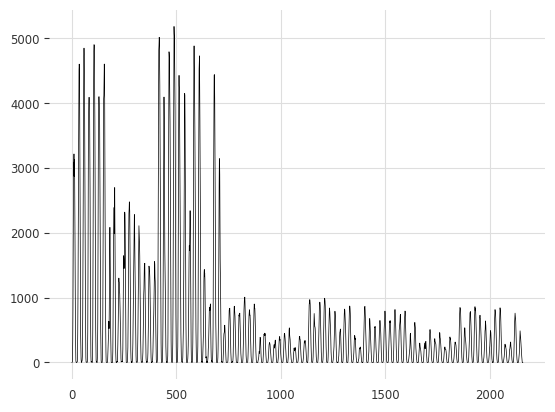

In [13]:
from darts.models import CatBoostModel

tars_per = "1hour"
covs_per = "1hour"
type = "full"

ys_cat = {}

do_cat = True
if do_cat:
    for loc in locs:
        cat = CatBoostModel(lags=5*24, lags_future_covariates=(24,24))
        cat.fit(tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])
        ys_cat[loc] = cat.predict(n_1hour, tars[tars_per][loc][type], future_covariates=covs[covs_per][loc][type])

y = extract_and_save(ys_cat, "cat_boost_1hour.csv")
y["prediction"].plot(lw=0.5)